# Imports, hyperparameters and functions

### Imports

In [60]:
from __future__ import print_function
from termcolor import colored,cprint # enable color in print statements

import keras
import tensorflow as tf
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import metrics, objectives, backend as K
from keras.datasets import mnist

import numpy as np

import matplotlib.pyplot as plt

In [61]:
print('Keras version: ', keras.__version__)
print('Tensorflow version: ', tf.__version__)

Keras version:  2.2.4
Tensorflow version:  1.13.1


### Hyperparameters

In [62]:
# Set the hyperparameters
#------------------------------
batch_size = 100
original_dim = 28 * 28 # original dimension of an image (height x width)
latent_dim = 2
intermediate_dim = 256
no_epochs = 50
epsilon_std = 1.0

### Functions

In [63]:
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Variational Autoencoders

In [64]:
# DEFINE THE ENCODER
#------------------------------
# Input to the encoder
x = Input(shape = (original_dim, ), name = 'input')

# Intermediate layer
h = Dense(intermediate_dim, activation = 'relu', name = 'encoding')(x)

# Define the mean of the latent space
z_mean = Dense(latent_dim, name = 'mean')(h)

# Define the log variance of the latent space
z_log_var = Dense(latent_dim, name = 'log-variance')(h)

z = Lambda(sampling, output_shape = (latent_dim, ))([z_mean, z_log_var])

# Encoder
encoder = Model(x, [z_mean, z_log_var], name = 'encoder')
print(colored('ENCODER', 'red'))
encoder.summary()

ENCODER
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 784)          0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
la

In [65]:
# DEFINE THE DECODER
#------------------------------
# Input to the decoder
input_decoder = Input(shape = (latent_dim, ), name = 'decoder_input')

# Takes the latent space to the intermediate dimension
decoder_h = Dense(intermediate_dim, activation = 'relu', name = 'decoder_h')(input_decoder)

# Gets the mean from the original dimension
x_decoded = Dense(original_dim, activation = 'sigmoid', name = 'flat_decoded')(decoder_h)

# Decoder
decoder = Model(input_decoder, x_decoded, name = 'decoder')
print(colored('DECODER', 'blue'))
decoder.summary()

DECODER
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               768       
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Combine encoder and decoder into a single VAE model
#------------------------------
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Define the loss function
#------------------------------
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,
             z_log_var = z_log_var, 
             z_mean = z_mean,
             original_dim = original_dim):
    
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    
    # Kullback-Leibler divergence
    kl_loss = - 0.5 * K.sum(
        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
    
    vae_loss = K.mean(xent_loss + kl_loss)
    
    return vae_loss

vae.compile(optimizer='rmsprop', loss = vae_loss)
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [68]:
# Get the data
#------------------------------
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [69]:
# Training
#------------------------------
vae.fit(x_train, x_train,
        shuffle = True,
        epochs = no_epochs,
        batch_size = batch_size)

Epoch 1/50
60000/60000 [==============================] - 6s 95us/step - loss: 189.8378
Epoch 2/50
60000/60000 [==============================] - 5s 82us/step - loss: 169.8566
Epoch 3/50
60000/60000 [==============================] - 5s 77us/step - loss: 166.8413
Epoch 4/50
60000/60000 [==============================] - 5s 87us/step - loss: 164.8292
Epoch 5/50
60000/60000 [==============================] - 5s 82us/step - loss: 163.2769
Epoch 6/50
60000/60000 [==============================] - 5s 80us/step - loss: 161.9499
Epoch 7/50
60000/60000 [==============================] - 5s 80us/step - loss: 160.7352
Epoch 8/50
60000/60000 [==============================] - 5s 80us/step - loss: 159.6215
Epoch 9/50
60000/60000 [==============================] - 5s 81us/step - loss: 158.6617
Epoch 10/50
60000/60000 [==============================] - 5s 81us/step - loss: 157.8948
Epoch 11/50
60000/60000 [==============================] - 5s 81us/step - loss: 157.2279
Epoch 12/50
60000/60000 [=====

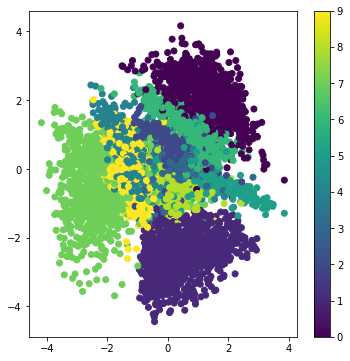

In [70]:
# display a 2D plot of the digit classes in the latent space
#------------------------------
x_test_encoded = encoder.predict(x_test, batch_size = batch_size)[0]
plt.figure(figsize = (6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap = 'viridis')
plt.colorbar()
plt.show()

/Users/itacdonev/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


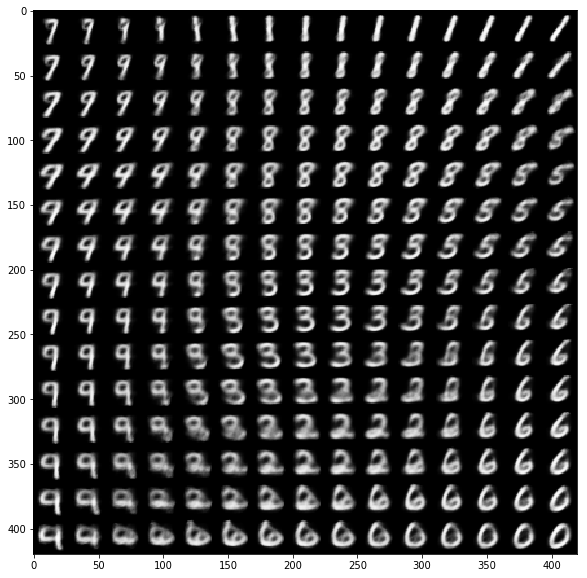

In [72]:
from scipy.stats import norm
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()